**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 3: Autoencoders Variacionales

**Profesor**: Felipe Tobar

**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.
**Ayudante**: Joaquín Barceló.  
**Nombre**: Arturo Lazcano

**Fecha de entrega**: 13 de octubre 2023

**Instrucciones**: El siguiente laboratorio consiste de una parte teórica y otra práctica, este código corresponde a la parte práctica, mientras que la parte teórica tiene preguntas en un archivo .pdf aparte. La ponderaciones son $50\%$ para cada parte.Deben entregar:
- Un reporte en formato PDF (extensión máxima de 4 páginas) con sus respuestas de la parte teórica. Puede ser a mano si lo desea, pero debe ser legible. NO es necesario entregar un infore de la parte práctica.
- Un archivo de extensión .ipynb donde contenga el código con sus respuestas a la parte práctica. Este debe seguir el formato de base (ser copia) del notebook entregado en material docente/repositorio.

Algunos links útiles:

* [Auto-Encoding Variational Bayes (Kingma, Welling 2014)](https://arxiv.org/abs/1312.6114)
* [From Autoencoder to Beta-VAE (Lilian Weng's blog, 2018)](https://lilianweng.github.io/posts/2018-08-12-vae/)

In [ ]:
!nvidia-smi

Fri Oct  6 23:03:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Resumen de preguntas

- [ ] a) (0,5 ptos.) VAE como Modelo Gráfico
- [ ] b) (0.5 ptos.) Truco de reparametrización
- [ ] c) (1 pto.) Encoder en clase VAE
- [ ] d) (1 pto.) Decoder en clase VAE
- [ ] e) (0.5 ptos.) Método _forward_.
- [ ] f) (1 pto.) Términos de la función de costos.
- [ ] g) (0.5 ptos.) Muestreo en espacio latente.
- [ ] h) (1 pto.) VAE condicional.

## Cargar & Visualizar MNIST dataset

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dataset

import matplotlib.pyplot as plt
from matplotlib import gridspec

from IPython.display import Image

%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Utilizaremos el emblematico MNIST dataset con imágenes escritas a mano, todas con
dimensión `1 x 28 x 28`. El dataset contiene 60k y 10k de imagenes en blango y negro para entrenamiento y pruebas respectivamente.

In [ ]:
batch_size = 128

mnist_dataset = dataset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


In [ ]:
len(mnist_dataset)

60000

Observemos las imágenes de un batch de datos con la función `show_batch`.

In [ ]:
def show_batch(images, CMAP='gray'):
    images = images.view(images.shape[0], -1)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrt_img = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrt_img, sqrt_img]), cmap=CMAP)
    return


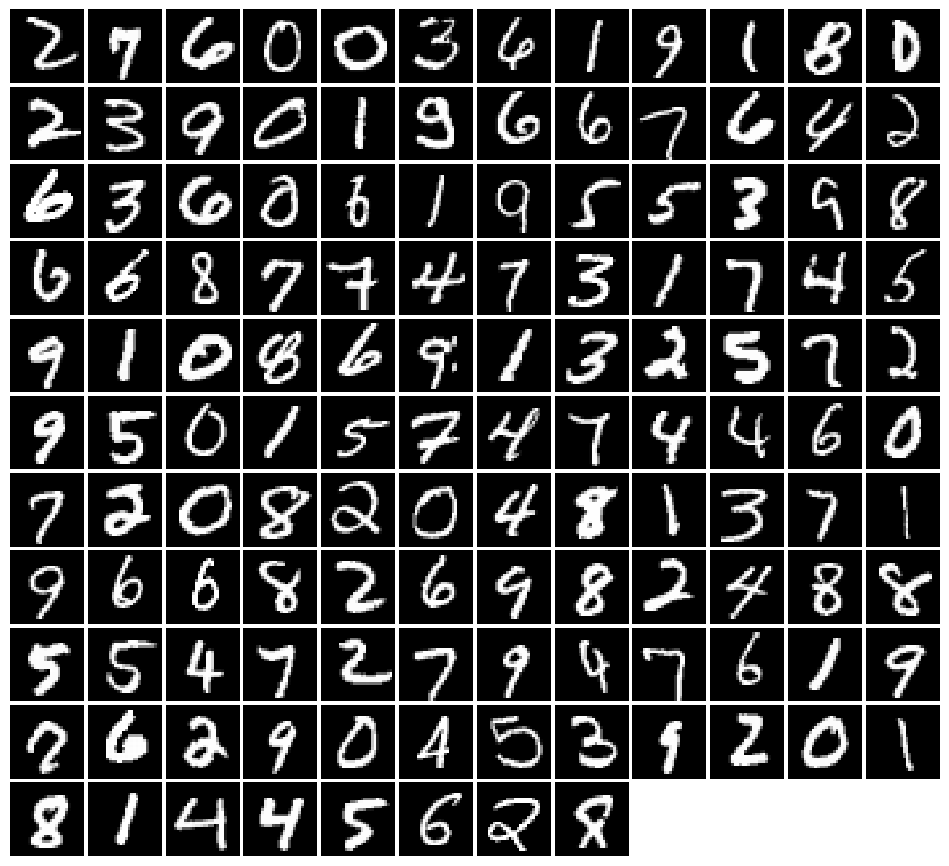

In [ ]:
# Obtenemos un batch de prueba para visualizar
xb, yb = next(iter(loader_train))
show_batch(xb)

## VAE

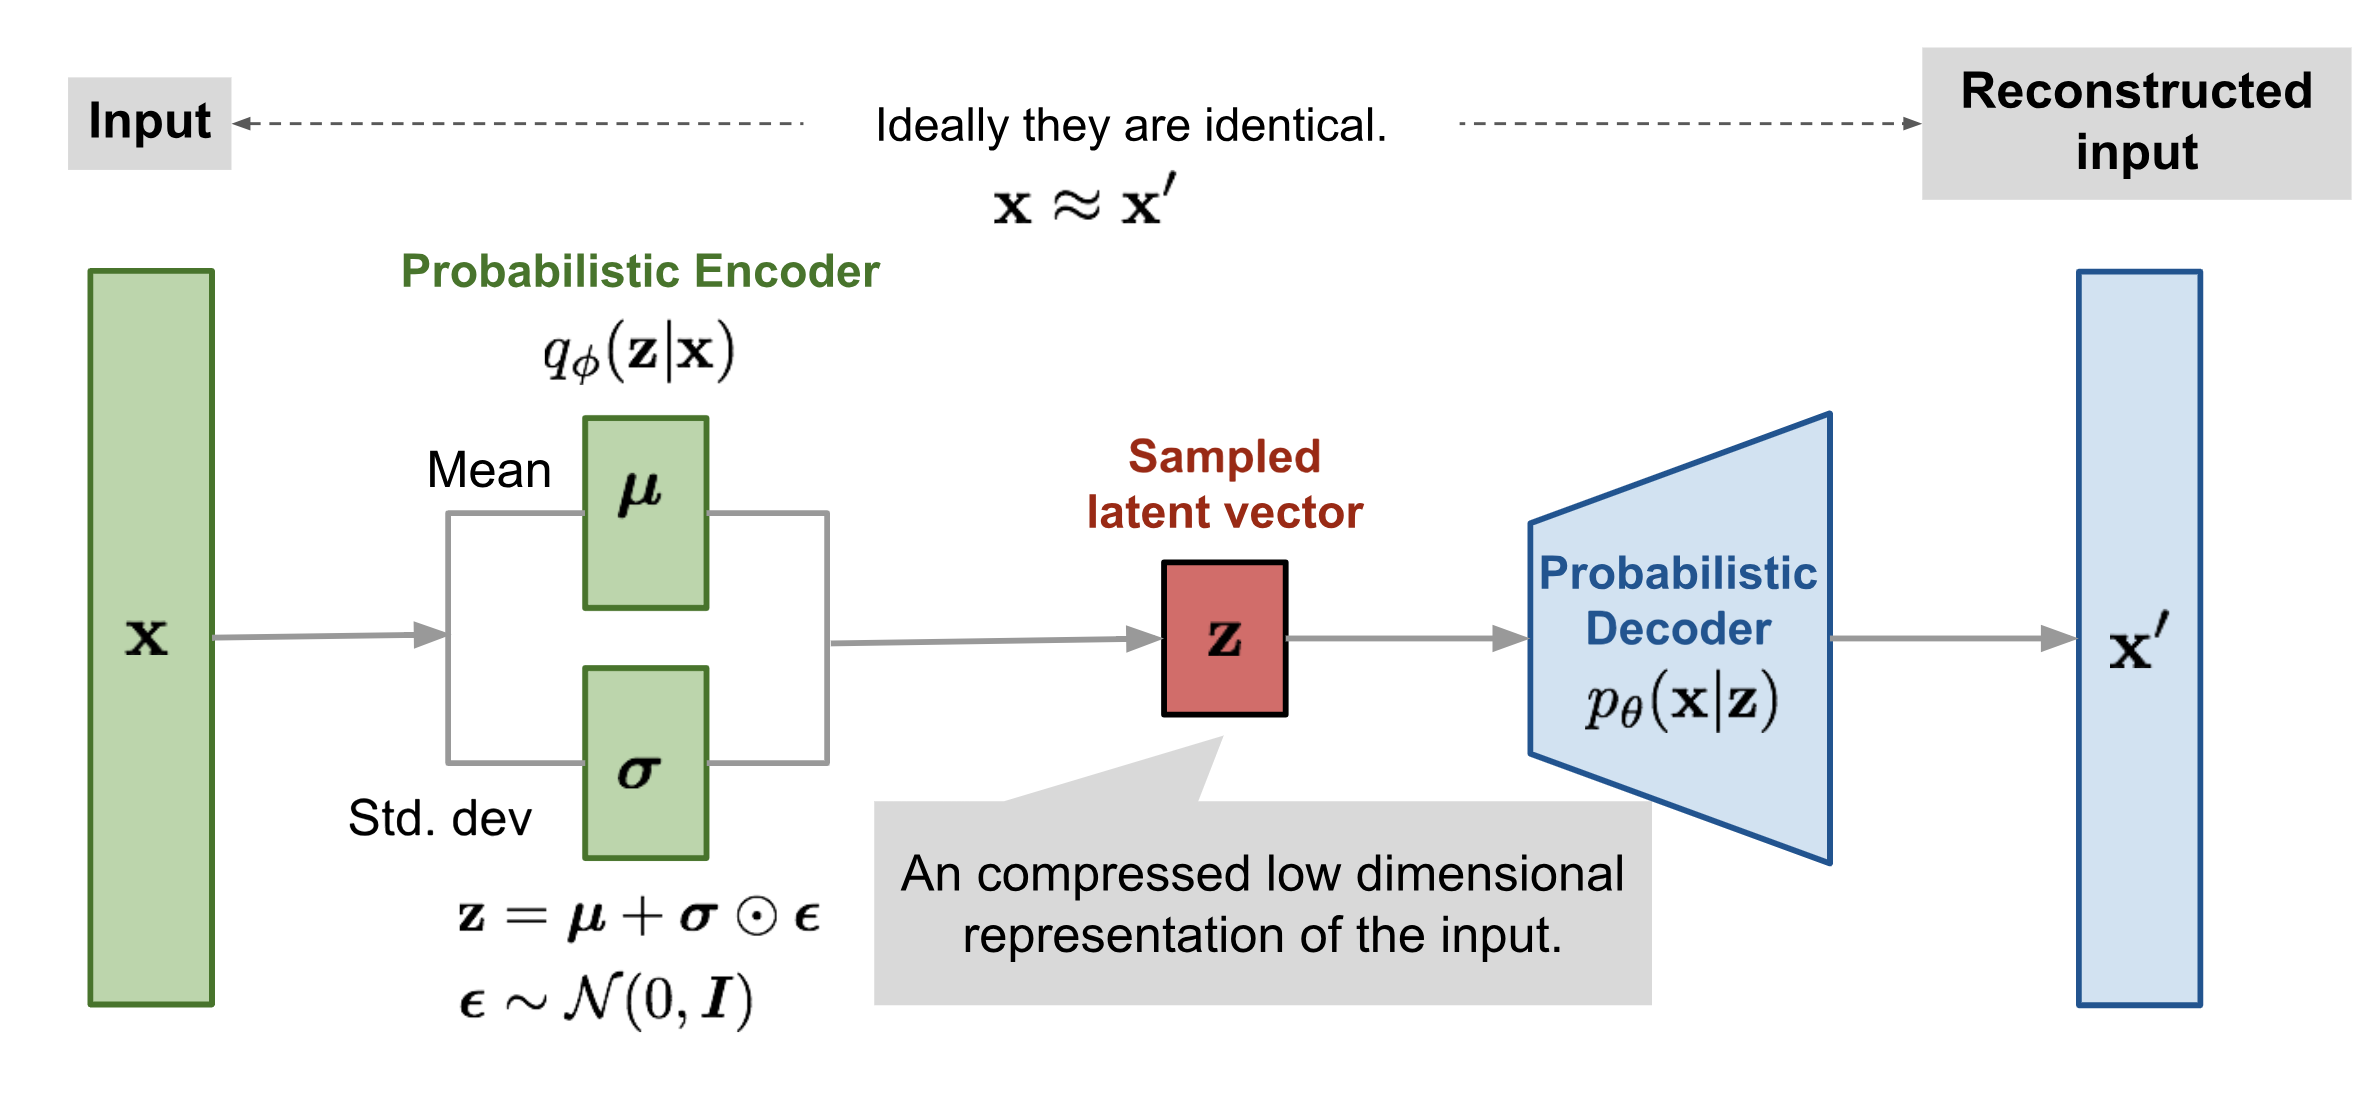

In [ ]:
# "Source: Lilian Weng Blog"
Image("https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/imgs/vae-gaussian.png",retina=True)

El objetivo de este laboratorio es implementar un Autoencoder Variacional, comprendiendo los 3 elementos principales que conforman su arquitectura, y se pueden ver en el diagrama de arriba que muestra la perspectiva de la red:

1. Encoder Probabilistco
2. Espacio Latente
3. Decoder Probabilistico

Dentro de la primera unidad del curso, estudiamos Graphical Models, por lo que es útil ver la formulación VAE también desde esta perspectiva.

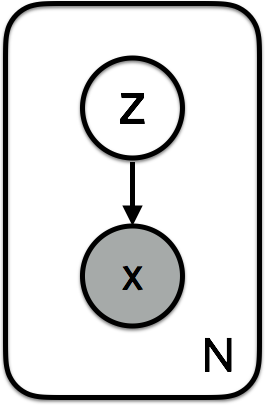

In [ ]:
Image("https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/imgs/graphical-model-variational-autoencoder.png")

> (a) (0.5 pts) Formule el graphical model para el contexto de VAE.




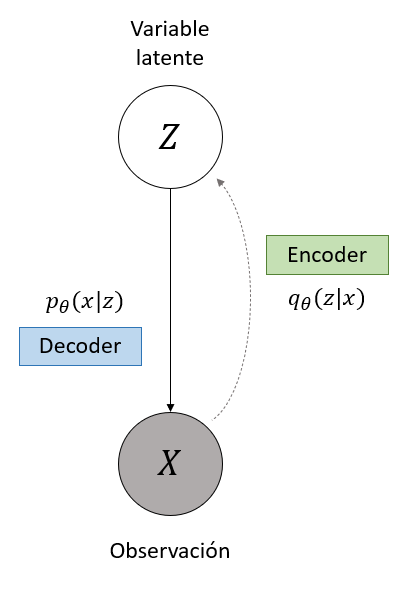

En la figura de arriba se puede observar la formulación de VAE como modelo gráfico. Notar que la variable $X$ es la observación mientras que $Z$ es la variable latente.  
Por otro lado, se pueden ver las flechas indicando el encoder o el decoder dependiento de donde salen (y a donde van) junto con sus formulaciones probabilisticas para cada uno.

## El truco de la reparametrización

Antes de comenzar a ensamblar el modelo, nos detendremos en un paso fundamental, samplear un vector del espacio latente.

Necesitamos que la operación de sampleo sea compatible con el proceso de entrenamiento de la red, es decir, obtener una expresión para $z$ que podamos computar sus derivadas parciales respecto a los parámetros de la distribución que estamos sampleando (e.g. $\mu$, $\sigma$), y así propagar los errores por la red durante el _backward pass_.

Por lo tanto, no podemos samplear $z$ directamente de una $\mathcal{N}(\mu, \sigma)$ usando algo como `torch.normal(mu, sigma, size=(n,))`.

In [ ]:
torch.normal(0, 1, size=(10,))

tensor([-2.2655,  2.0684,  0.0791,  0.0121, -1.5654, -0.5429,  2.4083, -0.6782,
         0.3897, -1.3170])

Se requiere implementar el conocido truco de la reparametrización que nos permitirá manejar la estocasticidad del sampling de tal manera que sea posible computar los gradientes del error respecto a nuestra variable latente $z$, así como a los valores de los parámetros empleados usados por la distribución de la que fue sampleada. La siguiente figura ilustra el truco.

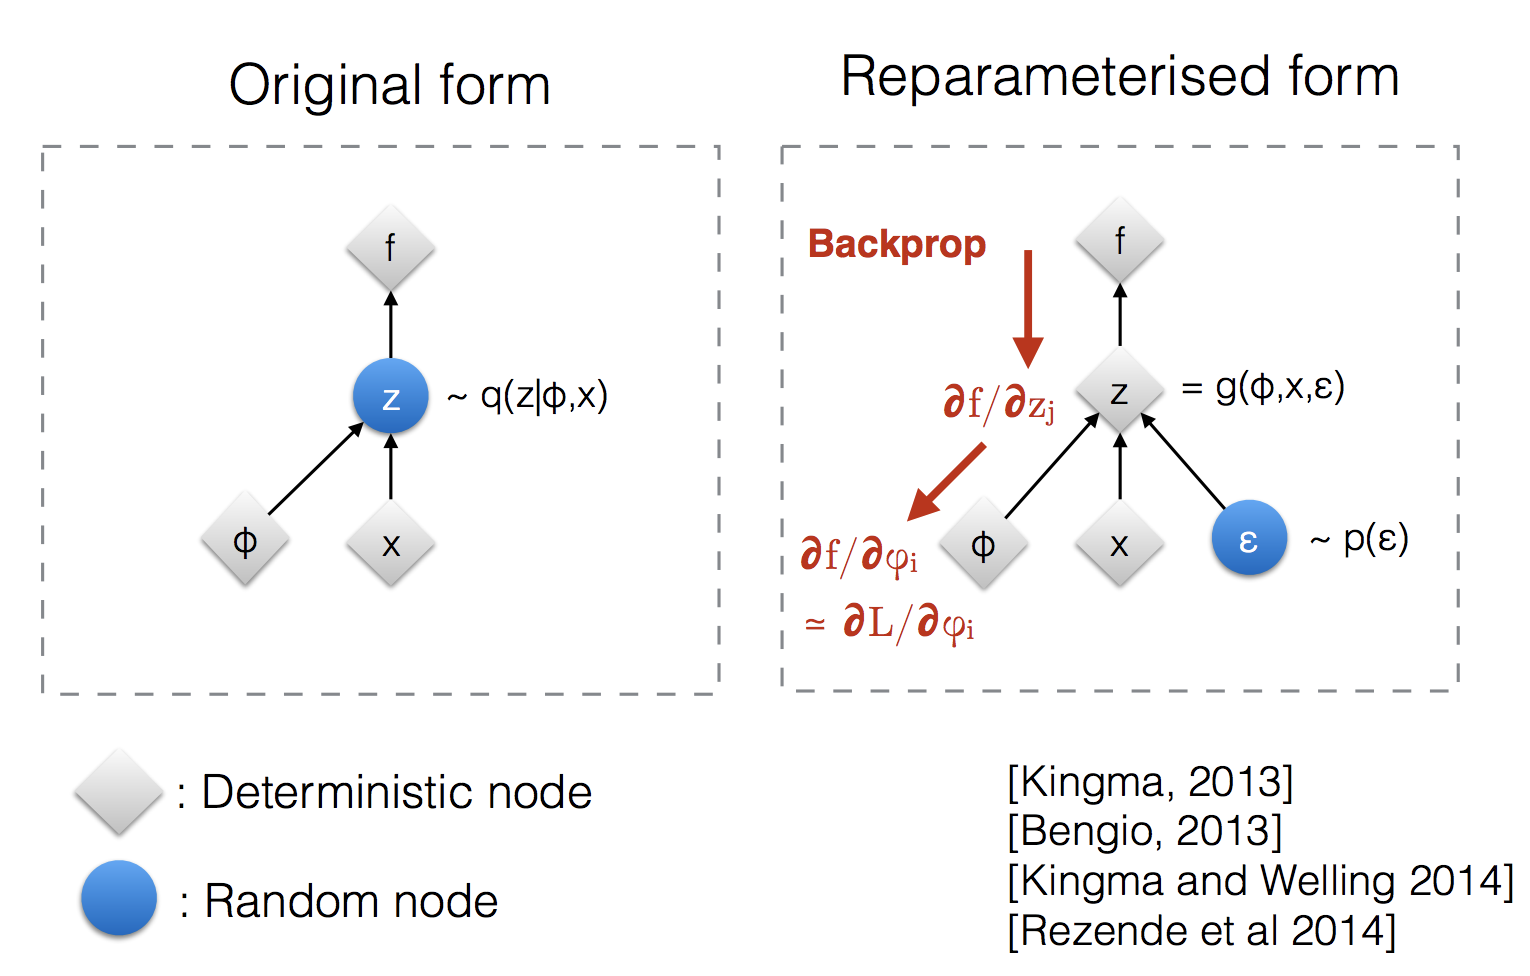

In [ ]:
# Source: Lilian Weng Blog
Image("https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/imgs/reparameterization-trick.png",
      retina=True)

Lo que logramos con el truco de la reparametrización es que la estocasticidad es independiente de los parámetros, por lo que nuestra muestra depende deterministicamente de los parámetros de la distribución.

> b) (0.5 pts) Implemente el truco de reparametrización para samplear de una normal dado
mu y logvar.

In [ ]:
# Se define la variable device porque a veces se usa cpu o cuda en la función de abajo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def reparameterization_trick(mu, logvar):
    """
        Inputs:
            - mu: Tensor con medias, (N, Z)
            - logvar: Tensor con las log-varianza, (N, Z)

        Retorna:
            - z: muestra del vector latente
    """
    # --------------------------------------------------------------------------
    # a) Implemente el truco de reparametrización

    std = torch.exp(logvar / 2)
    epsilon = torch.randn_like(std)
    epsilon = epsilon.to(device)
    z = mu + std*epsilon
    # --------------------------------------------------------------------------
    return z

## Fully Connected VAE

Ahora comencemos a construir nuestra red `VAE` fully connected. Esta desginación hace referencia al tipo de arquitectura que emplearemos para las funciones de codificación y decodificación. Usted debera implementar la clase `VAE` que se encuentra al final de esta sección, en particular, debe realizar el siguiente _checklist_.

- [ ] Bloque encoder, o codificador, con la arquiectura feed forward especificada.
- [ ] Capas lineales para los parámetros de la distribución normal que define nuestro espacio latente.
- [ ] Bloque decoder, o decodificador, con la arquitectura feed forward especificada.
- [ ] Método forward para el flujo de operaciones i/o de la red.


Empezaremos con el codificador, que tomará nuestras imágenes como entrada (después de aplanar la forma C,H,W a D) y las pasará a través de tres capas Lineales+ReLU. Usaremos esta representación de dimensión oculta para predecir tanto la media posterior como la log-varianza posterior utilizando dos capas lineales separadas (ambas con forma (N,Z)).

Tenga en cuenta que llamamos a una de las capas 'logvar' porque usaremos la log-varianza (en lugar de la varianza o la desviación estándar) para estabilizar el entrenamiento. Esto explica el nombre de uno de los parámetros de la función `reparameterization_trick` implementada en l sección anterior.


> c) (1 pts) Defina el `encoder`,  `hidden_dim` ($H$),  `mu_layer`, y  `logvar_layer` en la inicialización de la clase VAE. Utilizar las siguientes especificaciones para la arquitectura del `encoder`:
> * Capa fully connected con tamaño de input 784 (`input_size`) y output $H$ (`hidden_dim`)
> * `ReLU`
> * Capa fully connected con tamaño de input $H$ y output $H$
> * `ReLU`
> * Capa fully connected con tamaño de input $H$ y output $H$
> * `ReLU`


Luego, definiremos el decodificador, que toma como input la representación del espacio latente y reconstruye el input (i.e. imagen) a partir de esta representación compacta y probabilistica que buscamos aprender.

> d) (1 pts) Defina el bloque `decoder` con las siguientes especificaciones para su arquitectura:
> * Capa fully connected con tamaño de input igual al del espacio latente $Z$ (`latent_size`) y output $H$ (`hidden_dim`)
> * `ReLU`
> * Capa fully connected con tamaño de input $H$ y output $H$
> * `ReLU`
> * Capa fully connected con tamaño de input $H$ y output $H$
> * `ReLU`
> * Capa fully connected con tamaño de input $H$ y output 784 (`input_size`)
> * `Sigmoid`
> * `Unflatten` para volver a las dimensiones `1 x 28 x 28` originales

> e) (0.5 pts) Complete el método _forward_ de la clase `VAE`. Encargado de (i) pasar la imagen de input por el codificador y calcular las estimaciones para `mu` y `logvar`, luego (ii) usar el `reparameterization_trick`, implementado en la sección anterior, para obtener una estimación del espacio latente. Finalmente, (iii) pasará  esta represetación del espacio latente por el decodificador y generará una nueva imagen.

In [ ]:
class VAE(nn.Module):
    """
        Fully Connected VAE.
    """
    def __init__(self, input_size, hidden_dim=64, latent_size=16):
        super(VAE, self).__init__()
        self.input_size = input_size    # Height * Width
        self.latent_size = latent_size  # z
        self.hidden_dim = hidden_dim    # H

        # Bloque Encoder
        # ----------------------------------------------------------------------
        # a) Define arquitecture para bloque encoder, y las capas mu_layer, y
        #    logvar_layer
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_size),
            nn.ReLU(),
            )

        self.mu_layer = nn.Linear(latent_size, latent_size)
        self.logvar_layer = nn.Linear(latent_size, latent_size)
        # ----------------------------------------------------------------------


        # Bloque Decoder
        # ----------------------------------------------------------------------
        # b) Definir la arquitectura para bloque decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
            )

        # ----------------------------------------------------------------------


    def forward(self, x):
        # ----------------------------------------------------------------------
        #  Implemente el forward pass considerando los siguientes pasos:
        #   (1) Pasar el batch por el encoder para obtener mu y logvariance
        #   (2) Reparametrizar para computar el vector latente z
        #   (3) Pasar z por el decoder para obtener la versión reconstruída de x

        x_reshape = x.reshape(x.shape[0], self.input_size)
        x_reshape = self.encoder(x_reshape)
        mu, logvar = self.mu_layer(x_reshape), self.logvar_layer(x_reshape)
        z = reparameterization_trick(mu, logvar)
        x_hat = self.decoder(z)
        # ----------------------------------------------------------------------
        return x_hat, mu, logvar


Siempre es un buen _sanity check_ que la data fluya correctamente por el modelo.

In [ ]:
# Probemos con un hidden_dim y latent_size arbitrarios
m = VAE(input_size=xb.shape[-1] * xb.shape[-2], hidden_dim=32, latent_size=16)

# Se crea el batch en cuda para no generar error de tensores en cpu vs cuda
xb_aux = xb
xb_aux = xb_aux.cuda()

m.cuda()
m(xb_aux)[0].shape

torch.Size([128, 1, 28, 28])

El _forward pass_ retorna 3 elementos: la reconstrucción de la imagen, la media posterior y la log-varianza posterior. Estos últimos dos elementos, tal como se vio en la clase y en la pregunta teoríca, serán utilizados para calcular la función de pérdida del modelo.

## Función de pérdida/costo

Recuerde que la función de costo del VAE está compuesta por dos términos: (i) el término de reconstrucción, que mide la diferencia entre la imagen reconstruida y la imagen original, y (ii) el término de divergencia KL, que mide la diferencia entre la distribución posterior y la distribución prior del espacio latente.

$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$

Ten en cuenta que esto es el negativo del límite inferior variacional que se estudio en la clase, lo que asegura que al minimizar este término de pérdida, estamos maximizando el límite inferior variacional. El término de pérdida de reconstrucción se puede calcular simplemente utilizando la pérdida de entropía cruzada binaria entre los píxeles de la entrada original y los píxeles de salida de nuestro decodificador (**Hint:** `F.binary_cross_entropy`). El término de divergencia KL trabaja para forzar que la distribución del espacio latente esté cerca de la distribución prior (estamos utilizando una distribución gaussiana normal estándar como nuestra distribución prior).

Para ayudarte, hemos derivado una forma no vectorizada del término de divergencia KL para ti.
Supongamos que $q_\phi(z|x)$ es una gaussiana diagonal de $Z$ dimensiones con media $\mu_{z|x}$ de forma $(Z,)$ y desviación estándar $\sigma_{z|x}$ de forma $(Z,)$, y que $p(z)$ es una gaussiana de $Z$ dimensiones con media cero y varianza unitaria. Entonces podemos escribir el término de divergencia KL como:

$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

Se debe adaptar a una versión vectorizada que funcione en mini lotes.


> f) (1 pts) Defina los términos `reconstruction_term` y `kl_divergence_term` de la función de costo.

Se sugiere la siguiente discusión sobre [porqué la función de costo a utilizar para el término de reconstrucción es `F.binary_cross_entropy` y no `F.mse_loss`](https://www.reddit.com/r/MachineLearning/comments/4ujr2s/comment/d5qj3m9/?utm_source=share&utm_medium=web2x).

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    """
    Computa la cota inferior de la evidencia negativa como terminos de la función
    de costo del VAE.

    Inputs:
    - x_hat: Data reconstruida del input con shape (N, 1, H, W)
    - x: Data input a evaluar con shape (N, 1, H, W)
    - mu: Matriz con las estimaciones de mu posterior (N, Z), con Z como
      dimensión del espacio latente
    - logvar: Matriz con las estimaciones de la varianza en espacio logaritmico (N, Z),
      con Z como dimensión del espacio latente

    Retorna:
    - loss: Tensor que contiene el escalar que representa la pérdida de la cota
      inferior de evidencia negativa
    """
    # --------------------------------------------------------------------------
    reconstruction_term = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence_term = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    # --------------------------------------------------------------------------
    loss = reconstruction_term + kl_divergence_term
    return loss


## Entrenamiento

In [ ]:
def train_vae(epoch, model, train_loader, conditional=False):
    """
    Entrena una epoca para el modelo VAE o ConditionalVAE

    Inputs:
    - epoch: # de epoca
    - model: VAE o ConditionalVae PyTorch model
    - train_loader: PyTorch Dataloader con la data de entrenamiento
    - conditional: Boolean que representa True para ConditionalVae, sino VAE
    """
    model.train()
    train_loss = 0
    num_classes = 10
    loss = None
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device="cuda:0")
        if conditional:
            one_hot_vec = torch.eye(num_classes)[labels].to(device="cuda")
            recon_batch, mu, logvar = model(data, one_hot_vec)
        else:
            recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch, loss.data))


In [ ]:
# Hiperparámetros
num_epochs = 50
input_size = 28*28
hidden_dim = 64
latent_size = 15
device = 'cuda'

# Modelo
vae_model = VAE(input_size, hidden_dim=hidden_dim, latent_size=latent_size)
vae_model.cuda()

# Train
for epoch in range(0, num_epochs):
    train_vae(epoch, vae_model, loader_train)

Train Epoch: 0 	Loss: 24741.441406
Train Epoch: 1 	Loss: 21413.134766
Train Epoch: 2 	Loss: 20347.316406
Train Epoch: 3 	Loss: 18522.345703
Train Epoch: 4 	Loss: 17708.835938
Train Epoch: 5 	Loss: 17280.843750
Train Epoch: 6 	Loss: 17657.980469
Train Epoch: 7 	Loss: 15636.396484
Train Epoch: 8 	Loss: 16178.701172
Train Epoch: 9 	Loss: 16674.347656
Train Epoch: 10 	Loss: 16454.210938
Train Epoch: 11 	Loss: 15631.448242
Train Epoch: 12 	Loss: 15546.927734
Train Epoch: 13 	Loss: 15778.166992
Train Epoch: 14 	Loss: 15106.305664
Train Epoch: 15 	Loss: 16130.068359
Train Epoch: 16 	Loss: 15755.384766
Train Epoch: 17 	Loss: 16175.141602
Train Epoch: 18 	Loss: 15260.855469
Train Epoch: 19 	Loss: 15451.537109
Train Epoch: 20 	Loss: 15560.912109
Train Epoch: 21 	Loss: 15732.845703
Train Epoch: 22 	Loss: 15726.650391
Train Epoch: 23 	Loss: 16175.826172
Train Epoch: 24 	Loss: 14787.574219
Train Epoch: 25 	Loss: 14568.744141
Train Epoch: 26 	Loss: 14976.924805
Train Epoch: 27 	Loss: 15942.698242
Tr

Para evaluar el rendimiento, se aumentaron las épocas de entrenamiento de este modelo, sin embargo, no hay demasiada diferencia entre 20 y 50 épocas. Notar que tampoco se usó al máximo el poder computacional que se tiene, sin embargo, se puede ver que con pocas iteraciones el modelo tiene un rendimiento bastante bueno y esto se puede ver en la generación de números en las siguientes celdas.

## Generando muestras 🎨

Después de entrenar nuestra red VAE, podemos aprovechar su capacidad para generar nuevos ejemplos. Este proceso implica simplemente el decodificador: inicializamos alguna distribución aleatoria para el espacio latente $z$ y generamos los nuevos ejemplos al pasar este vector latente al decodificador.


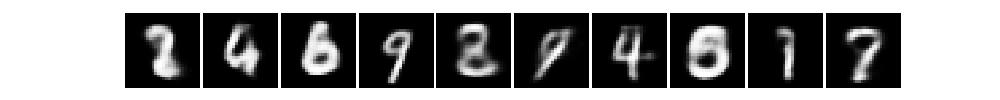

In [ ]:
Image("https://github.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/raw/main/labs/imgs/vae_gen_samples.jpg")

> g) (0.5 pts) Muestrear del espacio latente aprendido y generar una figura con 10 imágenes como la de arriba. El código para generar la visualización va por cuenta de la casa.

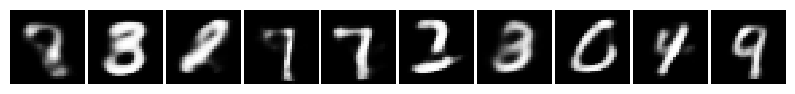

In [ ]:
# Puede modificar la ruta para guardar la imagen
SAVE_IMG_PATH = '.'

# ------------------------------------------------------------------------------
z = torch.randn(10, latent_size, dtype=torch.float).to(device)
samples = vae_model.decoder(z)
# ------------------------------------------------------------------------------

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28).cpu().detach().numpy())
    plt.savefig(os.path.join(SAVE_IMG_PATH,'vae_gen_samples.jpg'))

## Interpolación en el Espacio Latente

Como una prueba visual final de nuestro modelo VAE entrenado, podemos realizar interpolación en el espacio latente. Generamos vectores latentes aleatorios $z_0$ y $z_1$, y realizamos una interpolación lineal entre ellos; luego, ejecutamos cada vector interpolado a través del generador entrenado para producir una imagen.

Cada fila de la figura a continuación interpola entre dos vectores aleatorios. En su mayor parte, el modelo debería mostrar transiciones suaves a lo largo de cada fila, lo que demuestra que el modelo ha aprendido algo no trivial sobre la estructura espacial subyacente de los dígitos que está modelando.


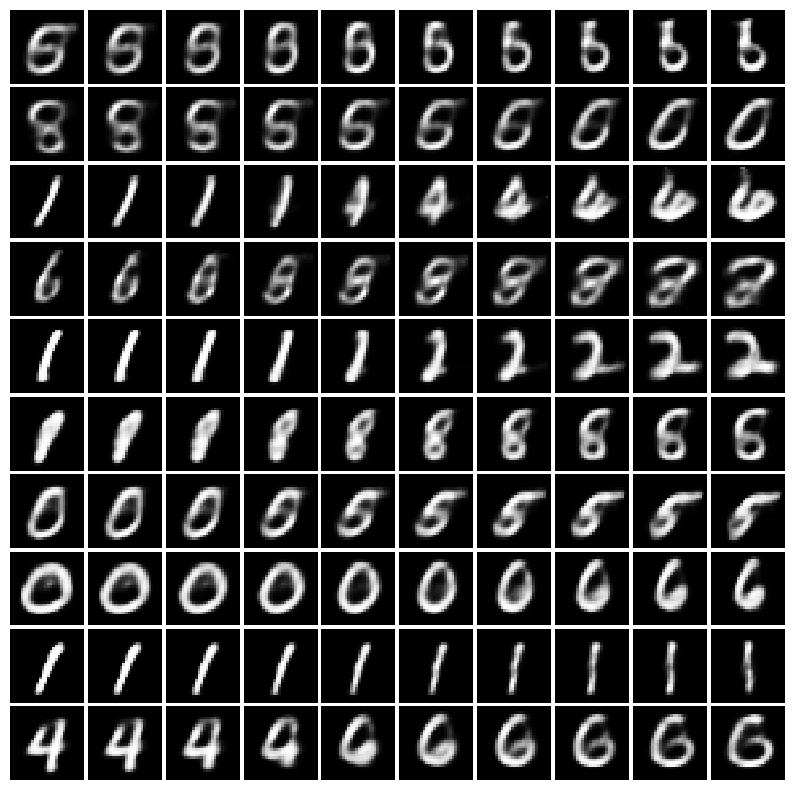

In [ ]:
S = 10
device = 'cuda'

z0 = torch.randn(S,latent_size , device=device)
z1 = torch.randn(S, latent_size, device=device)

w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, latent_size)
x_hat = vae_model.decoder(z)

show_batch(x_hat.data.cpu())

## Condicionar el modelo con las etiquetas


En esta última sección, implementaremos el modelo `ConditionalVAE`, una
variante cercana al `VAE`, pero con una condición adicional. Usaremos las etiquetas de las imágenes de MNIST para influir en la generación de imágenes dentro de categorías específicas. En lugar de trabajar solo con $q_{\phi} (z|x)$ y $p_{\phi}(x|z)$, ahora introducimos $q_{\phi} (z|x,c)$ y $p_{\phi}(x|z, c)$.

Esta modificación nos habilita para llevar a cabo generación condicional en la etapa de inferencia. Con ello, podremos elegir crear deliberadamente más 1s, 2s, 9s, y otras clases, en lugar de simplemente generar dígitos aleatorios.

La arquitectura del `ConditionalVAE` seguirá siendo similar a la de la clase `VAE` implementada, pero con una adición importante: incorporaremos un vector de etiquetas one-hot tanto en la entrada $x$ (las dimensiones de la imagen aplanada) como en el espacio latente $z$.

El vector one-hot se denominará 'c', donde 'c[label] = 1' y 'c = 0' en todas las demás ubicaciones.

Estas son las modificaciones a considerar:

1. Ajusta la primera capa lineal del encoder para que no solo reciba la imagen de entrada aplanada, sino también el vector one-hot de etiquetas 'c'.
2. Modifica la primera capa del decoder para proyectar el espacio latente combinado con el vector one-hot a la dimensión 'hidden_dim'.
3. Finalmente, en el paso 'forward', combina la imagen de entrada aplanada con los vectores one-hot (utilizando 'torch.cat') antes de pasarlos al encoder, y fusiona el espacio latente con los vectores one-hot (también con 'torch.cat') antes de enviarlos al decoder.


> h) (1 pts) Implemente la clase `ConditionalVAE` siguiendo las modificaciones indicadas.

In [ ]:
class ConditionalVAE(nn.Module):
    """
        Fully Connected Conditional VAE.
    """
    def __init__(self, input_size, num_classes=10, hidden_dim=64, latent_size=16):
        super(ConditionalVAE, self).__init__()
        self.input_size = input_size    # Height * Width
        self.num_classes = num_classes  # C
        self.latent_size = latent_size  # Z
        self.hidden_dim = hidden_dim    # H


        # Bloque Encoder
        # ----------------------------------------------------------------------
        # a) Define arquitecture para bloque encoder, y las capas mu_layer, y
        #    logvar_layer
        self.encoder = nn.Sequential(
            nn.Linear(input_size + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_size),
            nn.ReLU(),
            )

        self.mu_layer = nn.Linear(latent_size, latent_size)
        self.logvar_layer = nn.Linear(latent_size, latent_size)
        # ----------------------------------------------------------------------


        # Bloque Decoder
        # ----------------------------------------------------------------------
        # b) Definir la arquitectura para bloque decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
            )
        # ----------------------------------------------------------------------


    def forward(self, x, c):
        # ----------------------------------------------------------------------
        #  Implemente el forward pass considerando los siguientes pasos:
        #   (1) Pasar el batch con el input concatenado con un one-hot vector por
        #       el encoder para obtener mu y logvariance de la posterior
        #   (2) Reparametrizar para computar el vector latente z
        #   (3) Pasar z concatenado con un one-hot vector por el decoder para
        #       obtener la versión reconstruída de x

        # Encode
        x_reshape = x.reshape(x.shape[0], self.input_size)
        x_reshape = torch.cat((x_reshape, c), dim=-1)  # concatenar clases
        x_reshape = self.encoder(x_reshape)
        mu, logvar = self.mu_layer(x_reshape), self.logvar_layer(x_reshape)

        # Decode
        z = reparameterization_trick(mu, logvar)
        z = torch.cat((z, c), dim=-1)  # concatenar clases
        x_hat = self.decoder(z)
        # ----------------------------------------------------------------------
        return x_hat, mu, logvar

Entrenamos usando la misma función `train_vae`, pero con el argumento `conditional=True`.

In [ ]:
# Hiperparámetros
num_epochs = 50
input_size = 28*28
num_classes = 10
hidden_dim = 64
latent_size = 15
device = 'cuda'

# Modelo
conditional_vae_model = ConditionalVAE(input_size, num_classes=num_classes,
                                       hidden_dim=hidden_dim, latent_size=latent_size)
conditional_vae_model.cuda()

# Train
for epoch in range(0, num_epochs):
    train_vae(epoch, conditional_vae_model, loader_train, conditional=True)

Train Epoch: 0 	Loss: 22415.648438
Train Epoch: 1 	Loss: 19284.060547
Train Epoch: 2 	Loss: 18332.728516
Train Epoch: 3 	Loss: 17386.697266
Train Epoch: 4 	Loss: 17963.232422
Train Epoch: 5 	Loss: 16690.826172
Train Epoch: 6 	Loss: 15770.339844
Train Epoch: 7 	Loss: 15538.445312
Train Epoch: 8 	Loss: 15608.798828
Train Epoch: 9 	Loss: 15837.623047
Train Epoch: 10 	Loss: 15916.109375
Train Epoch: 11 	Loss: 15171.142578
Train Epoch: 12 	Loss: 15727.060547
Train Epoch: 13 	Loss: 14814.165039
Train Epoch: 14 	Loss: 14288.168945
Train Epoch: 15 	Loss: 15919.792969
Train Epoch: 16 	Loss: 15481.822266
Train Epoch: 17 	Loss: 14412.246094
Train Epoch: 18 	Loss: 14718.675781
Train Epoch: 19 	Loss: 14624.105469
Train Epoch: 20 	Loss: 14946.703125
Train Epoch: 21 	Loss: 14386.451172
Train Epoch: 22 	Loss: 14367.776367
Train Epoch: 23 	Loss: 14600.670898
Train Epoch: 24 	Loss: 14098.314453
Train Epoch: 25 	Loss: 15614.085938
Train Epoch: 26 	Loss: 14759.175781
Train Epoch: 27 	Loss: 14405.382812
Tr

Al igual que antes, se probó con 20 épocas inicialmente y se optó por probar más épocas. Con esto, el rendimiento del modelo fue bastante parecido, tal como pasó en la parte anterior. Esto quiere decir que, si se quiere ver una diferencia notable, se debe entregar mayor poder computacional y tener más tiempo a disposición.  
A pesar de lo anterior, los modelos entrnados, ya sean con 20 o 50 épocas, tienen un rendimiento bastante bueno en la generación de números y esto se puede ver visualmente en las siguientes imágenes:

Vamos a generar del 0 al 9 digitos.

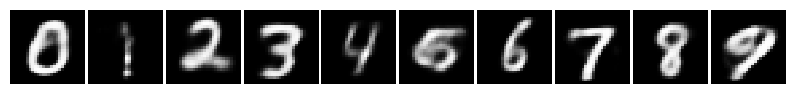

In [ ]:
n_samples = 10
z = torch.randn(n_samples, latent_size)
c = torch.eye(n_samples, 10) # [one hot labels for 0-9]

z = torch.cat((z,c), dim=-1).to(device='cuda')
conditional_vae_model.eval()
samples = conditional_vae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28))
    plt.savefig(os.path.join(SAVE_IMG_PATH,'conditional_vae_generation.png'), dpi=400)


Podemos generar muestras de un número que sea 70% del digito 3 y 30% del digito 7.

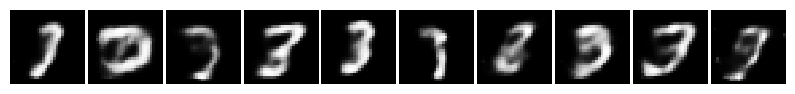

In [ ]:
n_samples = 10
z = torch.randn(n_samples, latent_size)
c_mix = torch.zeros(n_samples, 10)
c_mix[:, 3] = 0.7
c_mix[:, 7] = 0.3

z = torch.cat((z, c_mix), dim=-1).to(device='cuda')

conditional_vae_model.eval()
samples = conditional_vae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    #plt.imshow(sample.reshape(28, 28), cmap='Greys')
    plt.imshow(sample.reshape(28, 28))
    plt.savefig(os.path.join(SAVE_IMG_PATH,'conditional_vae_generation.png'), dpi=400)